In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introduction
We generated simulations reporting distances three distances: final gradient, standard deviation and final cell number. For figures 1-5 we use the final state values of a simulation to generate a jacobian matrix and find the eigenvalues. For Figure 6 we use the initial state values to generate a jacobian matrix and find the eigenvalues

We have three distances for each species here:
1. Final gradient < 100
2. Standard deviation of final 3000hrs < 10
3. Final species number> 1e3

Definitions:
* Early termination  - Simulation terminated early due to one or more infinitely decaying species
* Full term - A simulation that completes the full timeframe without being terminated.

Many simulations are terminated early to prevent overflow caused by an infinitely decaying species. We can therefore separate our simulations into "full term" and "early termination".


In [2]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 10]

font = {'size'   : 15, }
axes = {'labelsize': 'large', 'titlesize': 'large'}

mpl.rc('font', **font)
mpl.rc('axes', **axes)

import pandas as pd
import data_utils


In [3]:
# Paths to data csvs
wd = "/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp"
data_dir = wd + "/output/two_species_big_3/Population_0"
distances_path = data_dir + "/distances.csv"
eigenvalues_path = data_dir + "/eigenvalues_do_fsolve_state.csv"
model_space_report_path = data_dir + "/model_space_report.csv"


In [4]:
# Load dataframes
distances_df = pd.read_csv(distances_path)
eigenvalues_df = pd.read_csv(eigenvalues_path)

# Make distances numeric
distances_df = data_utils.distances_pre_processing(distances_df)

In [5]:
# Join eigenvalues and distances on the simulation index, batch number and model_ref
joint_df = pd.merge(left=eigenvalues_df, right=distances_df, how='inner', on=['sim_idx', 'batch_num', 'model_ref'])
joint_df.reset_index()

# Add columns indicating check results and summary stats
joint_df = data_utils.species_sustained(joint_df)
joint_df = data_utils.get_conjugate_pairs(joint_df)

joint_df = data_utils.make_max_eig(joint_df)
joint_df = data_utils.all_negative_eigs(joint_df)
joint_df = data_utils.all_real_eigs(joint_df)
joint_df = data_utils.all_positive_eigs(joint_df)
joint_df['sum_std'] = joint_df['d2'] + joint_df['d5']
joint_df['sum_grad'] = joint_df['d1'] + joint_df['d4']

# Set accepted or rejected particles
mask = (joint_df['d1'] < 100) & (joint_df['d2'] < 10) & (joint_df['d3'] > 1e3) & (joint_df['d4'] < 100) & (joint_df['d5'] < 10) & (joint_df['d6'] > 1e3)
joint_df.loc[mask, 'Accepted'] = True
joint_df.loc[~mask, 'Accepted'] = False

AttributeError: 'list' object has no attribute 'columns'

# Summary of results


Figure 1:<br>
Distributions of the leading eigenvalue for simulations that reach full term, compparing the eigenvalues of accepted and rejected simulations.
* The distributions of the max eigenvalue for the simulation end point of accepted and rejected simulations is small
* Some very large negative eigenvalues could be rejected here
<br><br>

Figure 2:<br>
Scatter plot of the sum of strain final gradients vs the leading eigenvalue
* No obvious correlation between the final gradient and the leading eigenvalue value
<br><br>

Figure 3:<br>
Scatter plot of the sum of strain standard deviations vs the leading eigenvalue
* No obvious correlation between the standard deviation and the leading eigenvalue value
* Very negative leading eigenvalues (less than -10^-6) usually result in very low standard deviations.
<br><br>

Figure 4:<br>
Comparison of the acceptance rate of real and complex eigensystems for full term simulations
* 25% of real eigensystems systems that reach full term are accepted
* 85% of complex eigensystems that reach full term are accepted
<br><br>

Figure 5:<br>
Comparison of the fraction of real and complex eigensystems that reach full term.
* 8% of real eigensystems reached full term 
* 35% of complex eigensystems reach full term
<br><br>


Figure 6:<br>
Distribution of eigenvalues taken from the initial state. We compare whether those simulations are able to reach full term or are terminated early. Note, upperlimit of eigenvalues visualised is imposed at -10, vast majority of simulations fall here.
* Very few simulations reaching fullterm when leading eigenvalue < -10^6. ~12% of simulations have leading eigenvalue falling in this range. Could be a good place to start cut particles without needing to simulate them.



## Final state eigenvalues dataset summary:
Note: 
Many simulations are terminated early to prevent overflow caused by an infinitely decaying species. We can therefore separate our simulations into "full term" and "early termination".



In [ ]:
all_sims = joint_df
full_term_sims = joint_df.loc[joint_df['integ_error'].isnull()]
early_termination_sims = joint_df.loc[~joint_df['integ_error'].isnull()]
only_real_part_sims = joint_df.loc[joint_df['all_real_eigs'] == True]
complex_sims = joint_df.loc[joint_df['all_real_eigs'] == False]
negative_part_sims = joint_df.loc[joint_df['all_negative_eigs'] == True]
positive_part_sims = joint_df.loc[joint_df['all_positive_eigs'] == True]

positive_real_part_sims = joint_df.loc[joint_df['all_positive_eigs'] == True]

only_real_and_full_term = joint_df.loc[joint_df['integ_error'].isnull() &
                                            (joint_df['all_real_eigs'] == True)]

accepted_sims = joint_df.loc[joint_df['Accepted'] == True]
rejected_sims = joint_df.loc[joint_df['Accepted'] == False]

# Total number of simulations
print("Total sims: ", len(all_sims))
print("Num accepted: ", len(accepted_sims))
print("Num rejected: ", len(rejected_sims))
print("")
# Number of simulations that exited before reaching full term
print("Sims reaching full term: ", len(full_term_sims))

# Number of sims that completed full term
print("Sims terminated early: ", len(early_termination_sims))
print("Sims reaching full term with only real parts: ", len(only_real_and_full_term))

print("")
# Number of sims that are all real parts
print("Sims with only real parts: ", len(only_real_part_sims))

# Number sims with only real eigen values
print("Sims with all negative real parts: ", len(negative_part_sims))


print("Sims with all positive real parts: ", len(positive_part_sims))

print("")
# Number of full term sims with only real eigenvalues


### Figure 1: distribution of max eigenvalues in full term simulations:
Below we plot frequency histograms for the leading eigenvale of each full term simulation.
1. Distribution of the leading eigenvalue for all full term simulations. No full term simulation had a positive leading eigenvalue
2. Distribution of the leading eigenvalue for accepted simulations.
3. Distribution of the leading eigenvalue for rejected simulations.

In summary, I think these distributions show it is difficult to distinguish between the accepted and rejected simulations looking at the leading eigenvalue alone. All simulatons are trending towards a fixed point, these can be with two species being sustained (accepted), one species dominating the system (rejected), or both species becoming extinct (rejected). The information here does not tell us if systems are unstable or stable (no differentiation between oscillators or spirals etc).

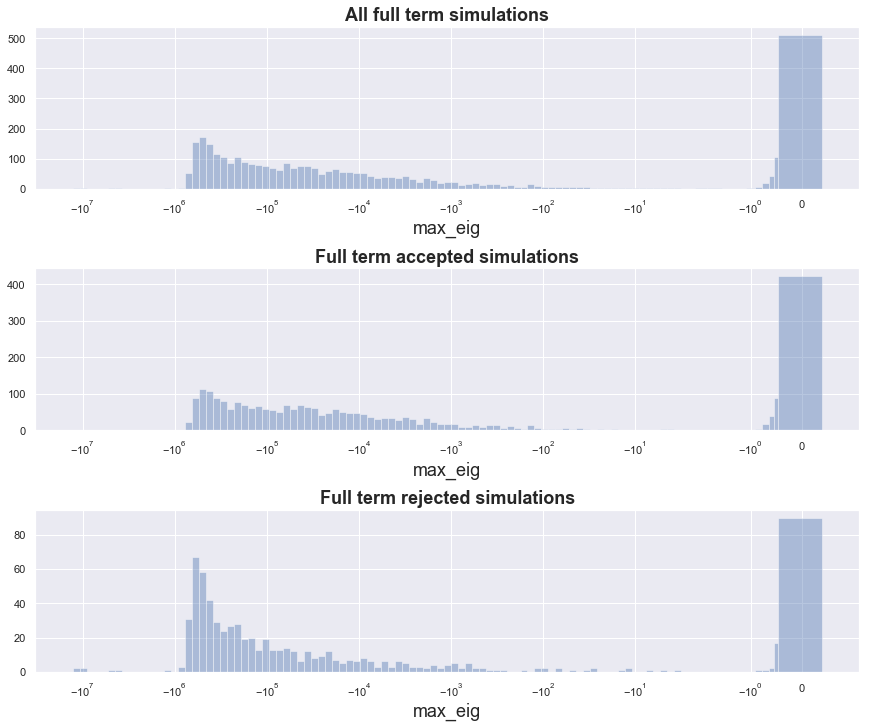

In [44]:
# Generate bins
n_bins=100
min_val = min(full_term_sims['max_eig'])
max_val = max(full_term_sims['max_eig'])

bin_signs = np.linspace(min_val, max_val, n_bins)

logbins = np.logspace(np.log10(abs(min_val)),np.log10(abs(max_val)), n_bins)
logbins = [np.sign(bin_signs[idx])*(abs(x)) for idx, x in enumerate(logbins)]

# # Transform bins to 'symlog scale'
# logbins = [np.sign(x)*np.log10(abs(x)) for x in bins]

# print(logbins)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True)

# Make bins
sns.distplot(full_term_sims['max_eig'], kde=False, bins=logbins, ax=ax1)
ax1.set_title('All full term simulations', fontweight="bold")


full_term_sims_acc = full_term_sims.loc[full_term_sims['Accepted'] == True]
full_term_sims_not_acc = full_term_sims.loc[full_term_sims['Accepted'] == False]

sns.distplot(full_term_sims_acc['max_eig'], kde=False, bins=logbins, ax=ax2)
ax2.set_title('Full term accepted simulations', fontweight="bold")

sns.distplot(full_term_sims_not_acc['max_eig'], kde=False, bins=logbins, ax=ax3)
ax3.set_title('Full term rejected simulations', fontweight="bold")

ax1.set(xscale='symlog')
ax2.set_xscale('symlog')
ax3.set_xscale('symlog')

plt.show()

<br><br>

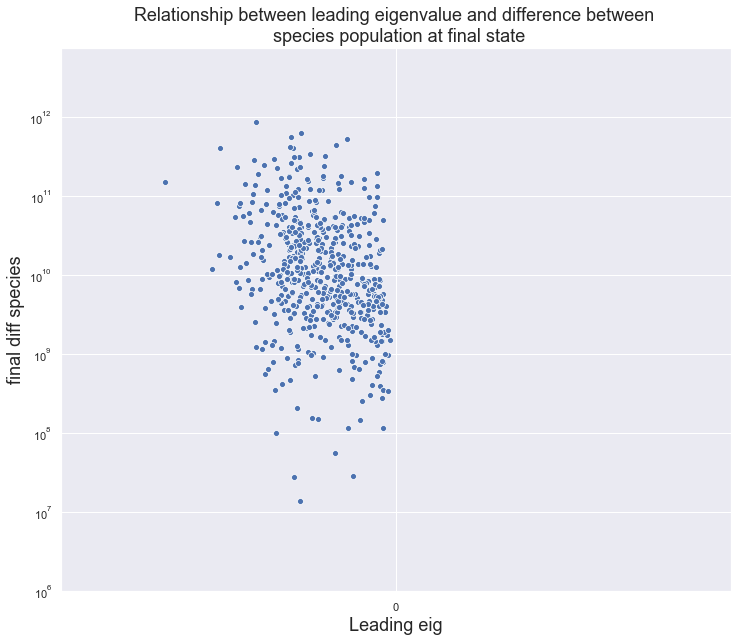

In [84]:
final_vals_cell_1 = all_sims['d3'].values
final_vals_cell_2 = all_sims['d6'].values

diff_final_vals = []
for idx, i in enumerate(final_vals_cell_1):
    diff = abs(final_vals_cell_1[idx] - final_vals_cell_2[idx])
    diff_final_vals.append(diff)

all_sims['diff_final_vals'] = diff_final_vals

full_term_sims_acc = full_term_sims.loc[full_term_sims['Accepted'] == True]
full_term_sims_all_negative = full_term_sims.loc[full_term_sims['all_real_eigs']==True]

full_term_sims_no_conj = full_term_sims_acc.loc[full_term_sims_acc['num_conj_pairs'] == 0] 
full_term_sims_one = full_term_sims_acc.loc[full_term_sims_acc['num_conj_pairs'] == 1] 
full_term_sims_two = full_term_sims_acc.loc[full_term_sims_acc['num_conj_pairs'] == 2] 

ax = sns.scatterplot(x='max_eig', y='diff_final_vals', data=full_term_sims_acc)
# ax = sns.scatterplot(x='max_eig', y='diff_final_vals', data=full_term_sims_one)
# ax = sns.scatterplot(x='max_eig', y='diff_final_vals', data=full_term_sims_two)

ax.set(xscale='symlog', yscale='symlog', xlabel='Leading eig', ylabel='final diff species')
ax.set(xlim=(-1.5, 1.5), ylim=(10**6, None))
plt.title('Relationship between leading eigenvalue and difference between \n species population at final state')
plt.savefig('diff_species_high_lead_eig.pdf')
plt.show()

### Figure 2: relationship between gradient and leading eigenvalue
Below is a scatterplot showing the relationship between the maximal eigenvalues and the sum pf the final gradient of the two strains. We show accepted (blue) and rejected (orange) simulations.

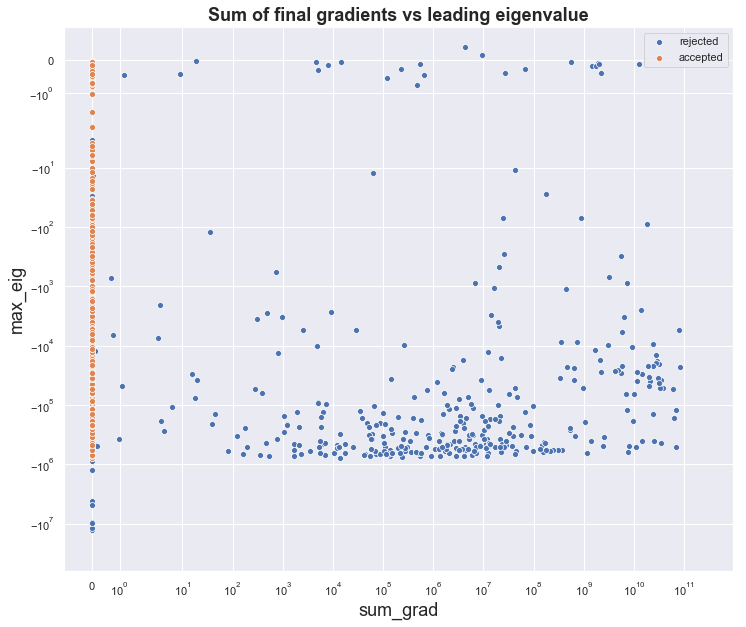

In [46]:
full_term_sims_acc = full_term_sims.loc[full_term_sims['Accepted'] == True]
full_term_sims_not_acc = full_term_sims.loc[full_term_sims['Accepted'] == False]

# Full term simulations only
ax = sns.scatterplot(x='sum_grad', y='max_eig', data=full_term_sims_not_acc, label='rejected')
ax = sns.scatterplot(x='sum_grad', y='max_eig', data=full_term_sims_acc, label='accepted')

ax.set(xscale='symlog', yscale='symlog')
ax.set(xlim=-1, ylim=(None, 1))
ax.set_title('Sum of final gradients vs leading eigenvalue', 
             fontweight="bold")
plt.show()

<br><br>

### Figure 3: relationship between standard deviation and leading eigenvalue
Below is a scatterplot showing the relationship between the leading eigenvalue and the sum of standard devations in the two species.

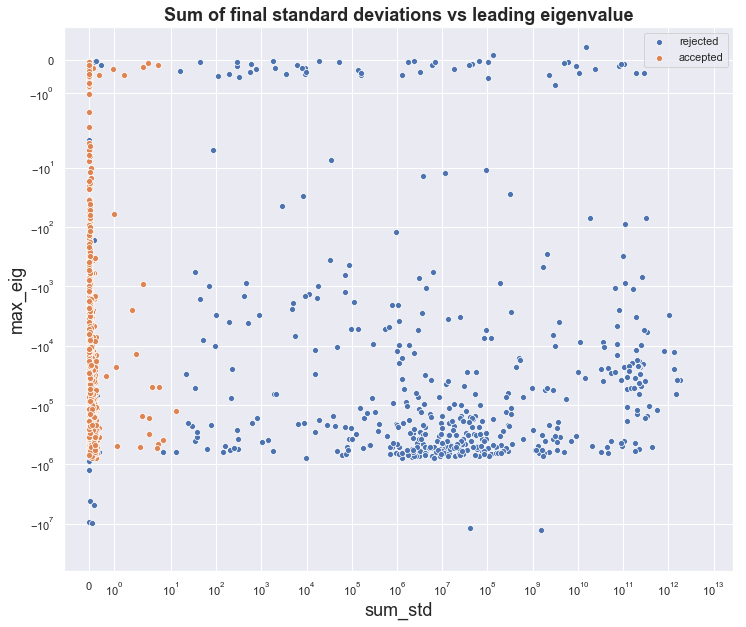

In [47]:
full_term_sims_acc = full_term_sims.loc[full_term_sims['Accepted'] == True]
full_term_sims_not_acc = full_term_sims.loc[full_term_sims['Accepted'] == False]

# Full term simulations only
ax = sns.scatterplot(x='sum_std', y='max_eig', data=full_term_sims_not_acc, label='rejected')
ax = sns.scatterplot(x='sum_std', y='max_eig', data=full_term_sims_acc, label='accepted')

ax.set(xscale='symlog', yscale='symlog')
ax.set(xlim=(-1, None), ylim=(None, 1))
ax.set_title('Sum of final standard deviations vs leading eigenvalue', 
             fontweight="bold")
plt.show()

<br><br>

### Figure 4: relationship between real, complex eigenvalues and particle acceptance
Complex eigenvalues are normally indicative of oscillatory systems. Are full term accepted solutions more likely to be real or complex?

Below, we split the full term simulations into those with entirely real only eigenvalues or complex eigenvalues (contain a mix or real and complex eivenvalues). Of the simulated paticles, we see a higher ratio of acceptance for complex eigensystems (orange), than real eigensystems (blue).

Vast majority of simulations with complex eigenvalues that reach full term are accepted.

Fraction of real systems accepted:  0.2835820895522388
Fraction of complex systems accepted:  0.8447780261897158


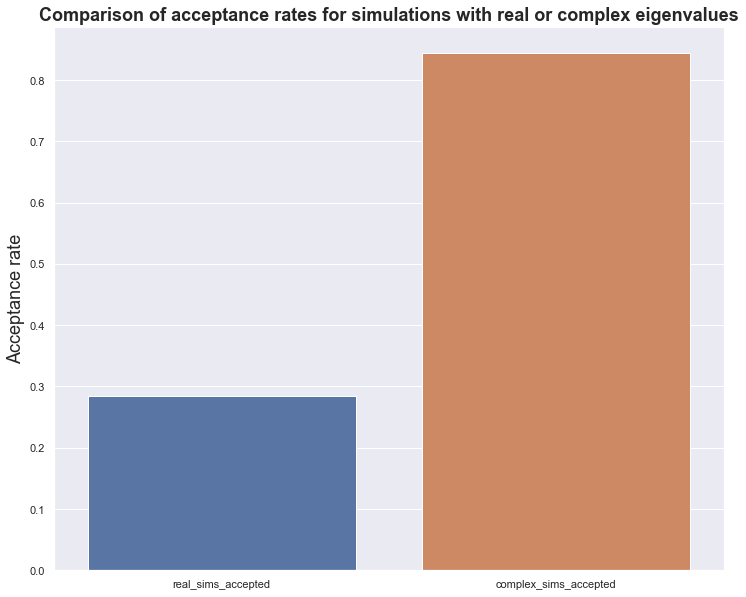

In [48]:
real_only_sims = full_term_sims.loc[full_term_sims['all_real_eigs'] == True]
complex_sims = full_term_sims.loc[full_term_sims['all_real_eigs'] == False]

real_only_sims_accepted = real_only_sims.loc[real_only_sims['Accepted'] == True]
complex_sims_accepted = complex_sims.loc[complex_sims['Accepted'] == True]

frac_real_sims_accepted = len(real_only_sims_accepted) / len(real_only_sims)
frac_complex_sims_accepted = len(complex_sims_accepted) / len(complex_sims)
print("Fraction of real systems accepted: ", frac_real_sims_accepted)
print("Fraction of complex systems accepted: ", frac_complex_sims_accepted)

x = ['real_sims_accepted', 'complex_sims_accepted']
y = [frac_real_sims_accepted, frac_complex_sims_accepted]
ax = sns.barplot(x=x,y=y)

ax.set(ylabel='Acceptance rate')
ax.set_title('Comparison of acceptance rates for simulations with real or complex eigenvalues', 
             fontweight="bold")

plt.show()

### Figure 5: relationship between real, complex eigenvalues and reaching full term
Below shows the fraction of simulations reaching full term with either real or complex eigensystems. 

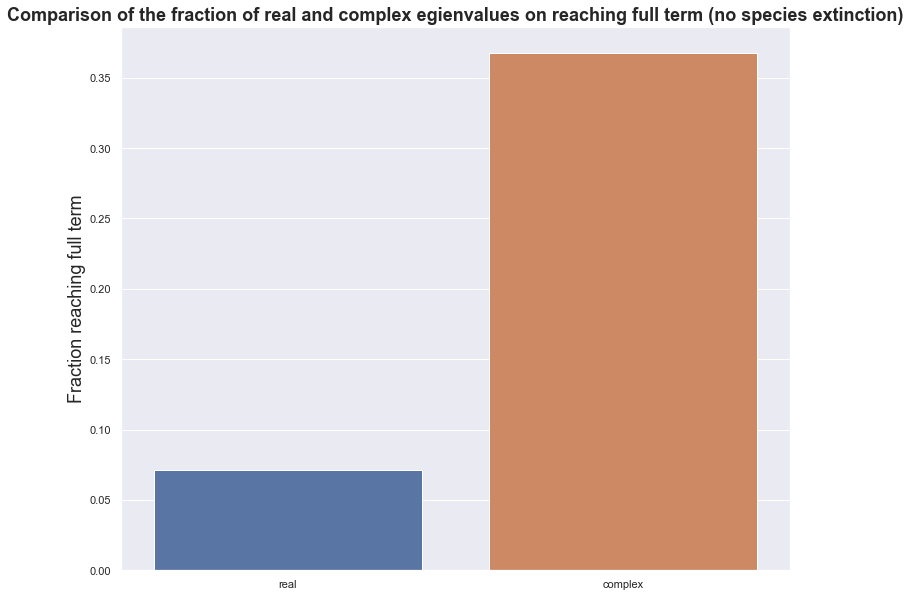

Fraction of real systems reaching full term:  0.07145904436860068
Fraction of complex systems reaching full term:  0.36783364661654133


In [49]:
complex_sims = joint_df.loc[joint_df['all_real_eigs'] == False]

frac_complex_full_term = len(complex_sims.loc[complex_sims['integ_error'].isnull()]) / len(complex_sims)
frac_real_full_term = len(only_real_and_full_term) / len(only_real_part_sims)

x = ['real', 'complex']
y = [frac_real_full_term, frac_complex_full_term]
ax = sns.barplot(x=x,y=y)

ax.set(ylabel='Fraction reaching full term')
ax.set_title('Comparison of the fraction of real and complex egienvalues on reaching full term (no species extinction)', 
             fontweight="bold")
plt.show()

print("Fraction of real systems reaching full term: ", frac_real_full_term)
print("Fraction of complex systems reaching full term: ", frac_complex_full_term)

In [50]:
# Paths to data csvs
wd = "/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp"
data_dir = wd + "/output/two_species_big_3/Population_0"
distances_path = data_dir + "/distances.csv"
eigenvalues_init_path = data_dir + "/eigenvalues_init_state.csv"
eigenvalues_end_path = data_dir + "/eigenvalues_end_state.csv"

model_space_report_path = data_dir + "/model_space_report.csv"




In [51]:
# Load dataframes
distances_df = pd.read_csv(distances_path)
eig_init_df = pd.read_csv(eigenvalues_init_path)
eig_end_df = pd.read_csv(eigenvalues_end_path)

# Make distances numeric
distances_df = data_utils.distances_pre_processing(distances_df)


# Add columns indicating check results and summary stats
eig_end_df = data_utils.make_max_eig(eig_end_df)

eig_end_df = data_utils.all_negative_eigs(eig_end_df)
eig_end_df = data_utils.all_real_eigs(eig_end_df)
eig_end_df = data_utils.all_positive_eigs(eig_end_df)


eig_init_df = data_utils.make_max_eig(eig_init_df)
eig_init_df = data_utils.all_negative_eigs(eig_init_df)
eig_init_df = data_utils.all_real_eigs(eig_init_df)
eig_init_df = data_utils.all_positive_eigs(eig_init_df)

init_real_part_sims = eig_init_df.loc[eig_init_df['all_real_eigs'] == True]
init_complex_sims = eig_init_df.loc[eig_init_df['all_real_eigs'] == False]
init_negative_part_sims = eig_init_df.loc[eig_init_df['all_negative_eigs'] == True]
init_positive_part_sims = eig_init_df.loc[eig_init_df['all_positive_eigs'] == True]

print("")
# Number of sims that are all real parts
print("Init state with only real parts: ", len(init_real_part_sims))
print("")
# Number sims with only real eigen values
print("Init state with all negative real parts: ", len(init_negative_part_sims))
print("")
# Number of sims with all positive parts
print("Init state all positive real parts: ", len(init_positive_part_sims))


FileNotFoundError: File b'/home/behzad/Documents/barnes_lab/cplusplus_software/speed_test/repressilator/cpp/output/two_species_big_3/Population_0/eigenvalues_init_state.csv' does not exist

### Figure 6: distribution of leading eigenvalues at initial state


Figures are cut to max eigenvalue of -10

In [ ]:
# Generate bins
n_bins=100
min_val = min(eig_init_df['max_eig'])
max_val = -10
bin_signs = np.linspace(min_val, max_val, n_bins)

logbins = np.logspace(np.log10(abs(min_val)),np.log10(abs(max_val)), n_bins)
logbins = [np.sign(bin_signs[idx])*(abs(x)) for idx, x in enumerate(logbins)]


eig_init_df_full_term = eig_init_df.loc[eig_init_df['integ_error'].isnull()]
eig_init_df_early_term = eig_init_df.loc[~eig_init_df['integ_error'].isnull()]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True)
sns.distplot(eig_init_df['max_eig'], kde=False, bins=logbins, ax=ax1)
sns.distplot(eig_init_df_full_term['max_eig'], kde=False, bins=logbins, ax=ax2)
sns.distplot(eig_init_df_early_term['max_eig'], kde=False, bins=logbins, ax=ax3)

ax1.set_title('All init state max eigenvalues', fontweight="bold")
ax2.set_title('Full term init state max eigenvalues', fontweight="bold")
ax3.set_title('Early temrination init state max eigenvalues', fontweight="bold")

ax1.set_xscale('symlog')
ax2.set_xscale('symlog')
ax3.set_xscale('symlog')

# ax3.set(xlim=[None, -10])
plt.show()

In [ ]:
print("Fraction of simulations with leading initial eigenvalue below -10**6:", len(eig_init_df.loc[eig_init_df['max_eig'] < -10**6])/len(eig_init_df))

### Analysing zero gradient simulations
Simulations where the gradients of the two strain species are zero in the final state of the simulation (d1 and d2 == 0.0).



In [ ]:
# Get zero gradient simulations
zero_gradient_sims = joint_df.loc[(joint_df['d1'] == 0.0) & (joint_df['d4'] == 0.0)]
accepted_sims = joint_df.loc[joint_df['Accepted'] == True]
print("Accepted simulations", len(accepted_sims))
print("Number of simulations with strain gradinents of zero", len(zero_gradient_sims))
print("Number of accepted zero gradient simulations", len(zero_gradient_sims.loc[zero_gradient_sims['Accepted'] == True]))

zero_grad_real = zero_gradient_sims.loc[zero_gradient_sims['all_real_eigs'] == True]
zero_grad_complex = zero_gradient_sims.loc[zero_gradient_sims['all_real_eigs'] == False]
zero_grad_all_negative = zero_gradient_sims.loc[zero_gradient_sims['all_negative_eigs'] == True]
print("")
print("Number of zero gradient sims with all real eigenvalues: ", len(zero_grad_real))
print("Number of zero gradient sims with complex eigenvalues: ", len(zero_grad_complex))
print("Number of zero gradient sims with all negative eigenvalues", len(zero_grad_all_negative))
print("")
print("Acceptance rate of zero gradient sims: ",  len(zero_gradient_sims.loc[zero_gradient_sims['Accepted']==True]) /len(zero_gradient_sims))
print("accepted zero gradient sims /  accepted sims: ", len(zero_gradient_sims.loc[zero_gradient_sims['Accepted']==True]) /len(accepted_sims))
print("")

In [ ]:
# Generate bins
n_bins=100
min_val = min(zero_gradient_sims['max_eig'])
max_val = max(zero_gradient_sims['max_eig'])
bin_signs = np.linspace(min_val, max_val, n_bins)

logbins = np.logspace(np.log10(abs(min_val)),np.log10(abs(max_val)), n_bins)
logbins = [np.sign(bin_signs[idx])*(abs(x)) for idx, x in enumerate(logbins)]

f, (ax1) = plt.subplots(1, 1, constrained_layout=True)
sns.distplot(zero_gradient_sims['max_eig'], kde=False, bins=logbins, ax=ax1)
ax1.set_xscale('symlog')
